## Data Visualisation 

Course Data Visualiation by Prof. Konrad Föstner 

Finn Heydemann, Master, Digital Science TH Köln 

Winter Semester 2022/23 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import os 
import matplotlib.pyplot as plt
import datetime

In [2]:
col_names = pd.read_csv("archive/columns_description.csv")["columns_en"]

### Raw Data is not included in github repository as it is too large. 
As I only work with minimzed data (6 weather stations only) you will not need it.  <br>
If for some reasons you do need the raw data, please download them yourself from: <br>
https://www.kaggle.com/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region

In [3]:
def read_single_w_station(filename: str, amount:int=1):
    station_gen = get_df_rows(filename)
    dfs = []
    for _ in range(amount): 
        rows_to_exclude = next(station_gen)
        df = pd.read_csv("archive/{}.csv".format(filename),
                         skiprows=rows_to_exclude, header=None)
        df.drop(0, axis=1, inplace=True)
        df.columns = col_names
        df["timestamp"] = pd.to_datetime((df["date"] + "-" + df["hour"]), format="%Y-%m-%d-%H:%M")
        df.drop(["date", "hour"], axis=1, inplace=True)
        df.set_index("timestamp", inplace=True)
        df.sort_index(inplace=True)
        df.replace(-9999, np.nan, inplace=True)
        dfs.append(df)
    return dfs


def get_df_rows(filename: str):
    np.random.seed(5)
    ids = np.unique(pd.read_csv("archive/{}.csv".format(filename),
                                usecols=["station_code"]))
    np.random.shuffle(ids)
    for st_id in ids:
        rows_to_keep = set(np.where(pd.read_csv("archive/{}.csv".format(filename),
                                            usecols=["station_code"]) == st_id)[0] + 1)
        num_lines = sum(1 for _ in open("archive/{}.csv".format(filename), encoding="utf-8"))
        yield set(range(num_lines)) - rows_to_keep

In [4]:
import os

def save_df(path, filename, df):
    if not os.path.exists(path): 
        os.mkdir(path)
    path = os.path.join(path, filename + ".csv")
    df.to_csv(path)

# only needed when working with raw data, else use functions below 
# takes a while as data is huge 
# activate by setting False to True
if False: 
    data = {x: read_single_w_station(x, 1) for x in ["central_west", "south", "north", "northeast", "southeast"]} 
    for key, value in data.items(): 
        for df in value:
            print(df.iloc[0]["station_code"])
            save_df("read_data", key + "_" + df.iloc[ 0]["station_code"], df)

In [6]:
for walker in os.walk("read_data"): 
    data = dict.fromkeys([x.rsplit("_", 1)[0] for x in walker[-1]], [])
    for file in walker[-1]: 
        df = pd.read_csv("read_data/" + file)
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df.set_index("timestamp", inplace=True)
        data[file.rsplit("_", 1)[0]].append(df)
        

In [70]:
len(data["southeast"])

5

central_west 0
timestamp
2020-01-01 00:00:00    21.6
2020-01-01 01:00:00    21.8
2020-01-01 02:00:00    21.6
2020-01-01 03:00:00    20.9
2020-01-01 04:00:00    20.9
                       ... 
2020-12-31 20:00:00    25.4
2020-12-31 21:00:00    23.6
2020-12-31 22:00:00    23.0
2020-12-31 23:00:00    22.1
2021-01-01 00:00:00    22.1
Name: max. temperature in the previous hour (°c), Length: 8785, dtype: float64
south 1
timestamp
2020-01-01 00:00:00    23.6
2020-01-01 01:00:00    22.8
2020-01-01 02:00:00    22.8
2020-01-01 03:00:00    23.1
2020-01-01 04:00:00    22.8
                       ... 
2020-12-31 20:00:00    28.4
2020-12-31 21:00:00    28.4
2020-12-31 22:00:00    28.4
2020-12-31 23:00:00    28.4
2021-01-01 00:00:00    28.4
Name: max. temperature in the previous hour (°c), Length: 8785, dtype: float64
northeast 1
timestamp
2020-01-01 00:00:00    23.6
2020-01-01 01:00:00    22.8
2020-01-01 02:00:00    22.8
2020-01-01 03:00:00    23.1
2020-01-01 04:00:00    22.8
                     

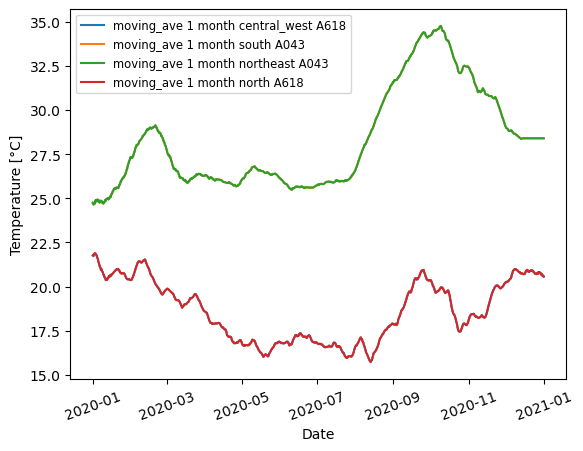

In [64]:
from scipy.ndimage import uniform_filter1d

def plot_temp(data, *keys, start_date, end_date, **kwargs): 
    fig, ax = plt.subplots()
    for key, index in keys:
        print(key, index)
        plot_data = data[key][index]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date),
                             "max. temperature in the previous hour (°c)"] 
        plot_data.fillna(method="ffill", inplace=True)
        if kwargs.get("raw"):
            plt.plot(plot_data, lw=0.5, label="raw temp data {key} {code}".format(key=key, index=index))
        print(plot_data)
        if kwargs.get("moving_mean"):
            filter_period, period_type = kwargs.get("mov_mean_period")
            if period_type == "month": 
                filter_period *= 30 * 24 
            elif period_type == "day": 
                filter_period *= 24
            plt.plot(plot_data.index, uniform_filter1d(plot_data.to_numpy(), 
                                                       filter_period), 
                     label="moving_ave {0} {1} {key} {code}".format(*kwargs.get("mov_mean_period"), 
                                                                   key=key, 
                                                                   code=data[key][index].iloc[0]["station_code"]))
    ax.set_ylabel("Temperature [°C]")
    ax.set_xlabel("Date")
    plt.xticks(rotation=20)
    plt.legend(fontsize="small")


plot_temp(data, 
          ("central_west", 0), 
          ("south", 1),
          ("northeast", 1),
          ("north", 0), 
          start_date=(2020, 1, 1), 
          end_date=(2021, 1, 1), 
          raw=False,
          moving_mean=True, 
          mov_mean_period=(1, "month"))

In [68]:
data["south"][1].loc[pd.Timestamp(2020, 1, 1): pd.Timestamp(2021, 1, 1),
                            "station_code"]

timestamp
2020-01-01 00:00:00    A043
2020-01-01 01:00:00    A043
2020-01-01 02:00:00    A043
2020-01-01 03:00:00    A043
2020-01-01 04:00:00    A043
                       ... 
2020-12-31 20:00:00    A043
2020-12-31 21:00:00    A043
2020-12-31 22:00:00    A043
2020-12-31 23:00:00    A043
2021-01-01 00:00:00    A043
Name: station_code, Length: 8785, dtype: object

In [69]:
data["northeast"][1].loc[pd.Timestamp(2020, 1, 1): pd.Timestamp(2021, 1, 1),
                            "station_code"]

timestamp
2020-01-01 00:00:00    A043
2020-01-01 01:00:00    A043
2020-01-01 02:00:00    A043
2020-01-01 03:00:00    A043
2020-01-01 04:00:00    A043
                       ... 
2020-12-31 20:00:00    A043
2020-12-31 21:00:00    A043
2020-12-31 22:00:00    A043
2020-12-31 23:00:00    A043
2021-01-01 00:00:00    A043
Name: station_code, Length: 8785, dtype: object

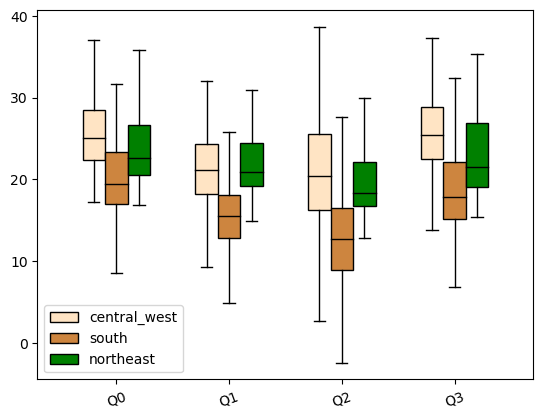

In [11]:
from itertools import cycle 

color = cycle(["bisque", "peru", "green", "lightblue", "plum"])

def boxplots(data, keys, start_date, end_date, seperator="Q"):
    """
    Makes a boxplot out of given data, start and end date can be defined as can be seperator which specifies 
    how data is seperated 
    
    # todo: If data is not present in one weather station, make sure plots are still on right quartil, month etc. 
    """
    w_stations = {}
    for key in keys: 
        plot_data = data[key]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                          "max. temperature in the previous hour (°c)"] 
        plot_data = plot_data.groupby(pd.Grouper(freq=seperator))
        d_single = {}
        for period in plot_data.groups.keys(): 
            x = plot_data.get_group(period).to_numpy()
            x[np.argwhere(np.isnan(x))] = np.nanmedian(x)
            d_single[period] = x
            
        w_stations[key] = d_single
    fig, ax = plt.subplots()
    elements = []
    for k, key in zip(np.linspace(-0.2, 0.2, len(keys)), keys):
        elements.append(ax.boxplot(w_stations[key].values(), 0, "", 
                                   positions=[k + l for l in range(len(w_stations[key]))],
                                   widths=0.2, 
                                   patch_artist=True, 
                                   boxprops={"facecolor":next(color)}, 
                                   medianprops={"color": "black"}
                                  ))
        
        plt.xticks(range(len(w_stations[key])), [seperator + str(j) for j in range(len(w_stations[key]))], 
                   rotation=20) 
    ax.legend([element["boxes"][0] for element in elements], [key for key in keys])

    
    
    
boxplots(data, ["central_west", "south", "northeast"], (2019, 1, 1), (2019, 12, 31), "Q")

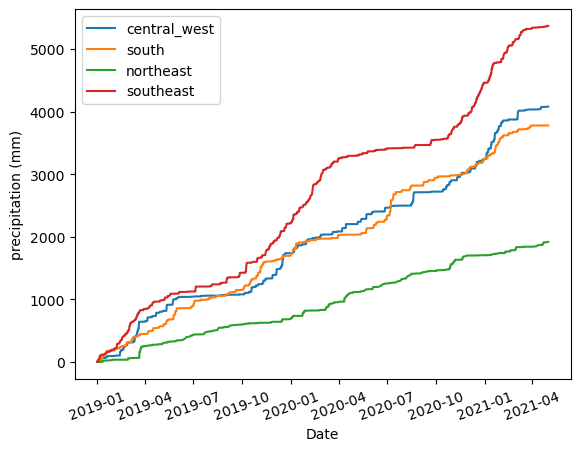

In [12]:
def cumulative_percipitation_plot(data, keys, start_date, end_date):
    fig, ax = plt.subplots()
    for key in keys: 
        plot_data = data[key]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                              ["total precipitation (mm)"]]
        plot_data.fillna(plot_data["total precipitation (mm)"].median(), inplace=True)
        plot_data["cumulative"] = np.cumsum(plot_data["total precipitation (mm)"])
        ax.plot(plot_data.index, plot_data["cumulative"].to_numpy(), label=key)
    ax.set_xlabel("Date")
    ax.set_ylabel("precipitation (mm)")
    plt.xticks(rotation=20)
    plt.legend()
    
    

cumulative_percipitation_plot(data, ["central_west", "south", "northeast", "southeast"], 
                              (2019, 1, 1), (2021, 12, 31))
    
    

In [13]:
import geopandas as gpd
shapefile = 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']

gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [14]:
df = data["central_west"]
df["latitude"].to_numpy()[0]

-22.955

In [15]:
df = {"name": [], "Latitude": [], "Longitude": []}
for key, value in data.items(): 
    df["name"].append(key)
    df["Latitude"].append(value.latitude.to_numpy()[0])
    df["Longitude"].append(value.longitude.to_numpy()[0])
    
df = pd.DataFrame(df)

<Axes: >

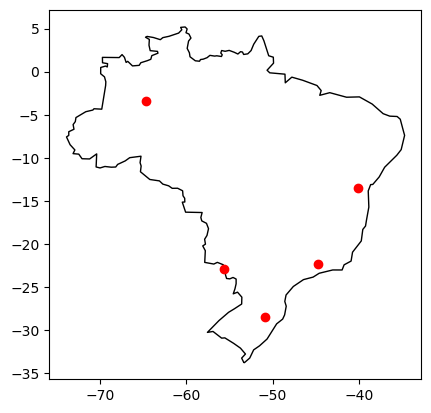

In [16]:
gxdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

ax = gdf[gdf["country"]=="Brazil"].plot(color="white", edgecolor="black")
gxdf.plot(ax=ax, color="red")

In [29]:
x = np.array([1, 2, 3, 4])
np.random.shuffle(x)
x

array([3, 2, 1, 4])